In [1]:
'''
In part 3 of this series, we will convert the trained model from part 2 into a ONNX model and then into a TensorRT engine.

This process will involve the following steps:
1. Load the trained model from part 2
2. Convert the model to ONNX format
3. Benchmark the model in ONNX format
4. Convert the ONNX model to a TensorRT engine
5. Benchmark the model in TensorRT format
6. Report on any performance improvements

'''
# from ..part_2.part_2_cifar import SimpleCNN

import os
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.onnx
import onnxruntime as ort
import numpy as np
import time
import yaml

from matplotlib import pyplot as plt


from tqdm import tqdm


BATCH_SIZE = 32

In [2]:
'''
Step 0: Define supporting functions
'''

class Config:
    def __init__(self, config_dict):
        self.batch_size = config_dict['batch_size']['value']
        self.dropout_rate = config_dict['dropout_rate']['value']
        self.epochs = config_dict['epochs']['value']
        self.learning_rate = config_dict['learning_rate']['value']
        self.momentum = config_dict['momentum']['value']
        self.num_filters_1 = config_dict['num_filters_1']['value']
        self.num_filters_2 = config_dict['num_filters_2']['value']
        self.num_filters_3 = config_dict['num_filters_3']['value']

# Load the configuration file - convert the YAML file to a dictionary
def load_config(filepath):
    with open(filepath, 'r') as file:
        config_data = yaml.safe_load(file)  # Use safe_load to load the YAML file

    # Create an instance of the Config class with the loaded data
    return Config({
        'batch_size': config_data['batch_size'],
        'dropout_rate': config_data['dropout_rate'],
        'epochs': config_data['epochs'],
        'learning_rate': config_data['learning_rate'],
        'momentum': config_data['momentum'],
        'num_filters_1': config_data['num_filters_1'],
        'num_filters_2': config_data['num_filters_2'],
        'num_filters_3': config_data['num_filters_3'],
    })


In [3]:
'''
Step 1: Load the trained model from part 2
'''

class SimpleCNN(nn.Module):
    def __init__(self, config):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=config.num_filters_1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=config.num_filters_1, out_channels=config.num_filters_2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=config.num_filters_2, out_channels=config.num_filters_3, kernel_size=3, padding=1)
        
		# Single batch normalization layer after the last conv layer
        self.bn = nn.BatchNorm2d(config.num_filters_3)
    
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(config.dropout_rate)
        
        # Fully connected layers
        final_size = config.num_filters_3 * 4 * 4
        self.fc1 = nn.Linear(in_features=final_size, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=100)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.bn(self.conv3(x))))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
wandb_files = '/nfs/aiteam/arjun/Development/others/ki/part_2/wandb/run-20240811_120827-cxlebjwx/files/'
config_path = os.path.join(wandb_files, 'config.yaml')
model_path = os.path.join(wandb_files, 'best_model/best_model.pth')

# read the config yaml file

config = load_config(config_path)
model = SimpleCNN(config)
model_state = torch.load(model_path)["model_state"]
model.load_state_dict(model_state)
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
)

In [4]:
'''
Step 2: Convert the model to ONNX format
'''
onnx_file_path = 'simple_cnn.onnx'

if not os.path.exists(onnx_file_path):
    # Dummy input as expected by the model, for example (1, 3, 32, 32) for CIFAR-100
    dummy_input = torch.randn(1, 3, 32, 32)

    # Export the model
    torch.onnx.export(model,               # model being run
                    dummy_input,         # model input (or a tuple for multiple inputs)
                    "simple_cnn.onnx",   # where to save the model (can be a file or file-like object)
                    export_params=True,  # store the trained parameter weights inside the model file
                    opset_version=10,    # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names = ['input'],   # the model's input names
                    output_names = ['output'], # the model's output names
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

else:
    print(f"ONNX file already exists at {onnx_file_path}\n change the file name or delete the existing file")

ONNX file already exists at simple_cnn.onnx
 change the file name or delete the existing file


In [5]:
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import onnxruntime as ort
import numpy as np
import time

'''
Step 3: Benchmark the model in ONNX format
'''

# Load the ONNX model
ort_session = ort.InferenceSession("simple_cnn.onnx")

# Function to run inference on the ONNX model
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Benchmarking on the test set
mean = [0.5059, 0.4860, 0.4411]
std = [0.2677, 0.2561, 0.2759]
transform_test = tt.Compose([
                            tt.ToTensor(), 
                             tt.Normalize(mean,std)
                             ])
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
total_time = 0
total_correct = 0
total_images = 0

for images, labels in test_loader:
    # Forward pass through ONNX model
    start_time = time.time()
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(images)}
    ort_outs = ort_session.run(None, ort_inputs)
    end_time = time.time()

    # Calculate the time taken
    total_time += (end_time - start_time)

    # Compute accuracy
    predicted = np.argmax(ort_outs[0], axis=1)
    total_correct += np.sum(predicted == to_numpy(labels))
    total_images += images.size(0)

print(f"🐮 ONNX Run")
print(f' >>> Accuracy: {total_correct / total_images * 100:.2f}%')
print(f' >>> Average inference time per batch: {total_time / len(test_loader):.6f} seconds')
print(f' >>> Model file size: {os.path.getsize("simple_cnn.onnx") / 1e6:.2f} MB')


Files already downloaded and verified
🐮 ONNX Run
 >>> Accuracy: 62.99%
 >>> Average inference time per batch: 0.017545 seconds
 >>> Model file size: 10.50 MB


In [6]:
'''
Step 3.5: Benchmark the model in pytorch format
'''

model = model.to('cuda')
total_time = 0
total_correct = 0
total_images = 0

for images, labels in test_loader:
    images = images.to('cuda')
    labels = labels.to('cuda')

    # Forward pass through the model
    start_time = time.time()
    outputs = model(images)
    end_time = time.time()

    # Calculate the time taken
    total_time += (end_time - start_time)

    # Compute accuracy
    _, predicted = torch.max(outputs, 1)
    total_correct += torch.sum(predicted == labels).item()
    total_images += images.size(0)

print(f"🐍 PyTorch Run")
print(f' >>> Accuracy: {total_correct / total_images * 100:.2f}%')
print(f' >>> Average inference time per batch: {total_time / len(test_loader):.6f} seconds')
print(f' >>> Model file size: {os.path.getsize(model_path) / 1e6:.2f} MB')

🐍 PyTorch Run
 >>> Accuracy: 62.99%
 >>> Average inference time per batch: 0.004303 seconds
 >>> Model file size: 21.02 MB


In [10]:
from torch2trt import torch2trt

# Setup the models
dummy_input = torch.randn(32, 3, 32, 32).cuda()
model_trt = torch2trt(model, [dummy_input])

# Reset metrics
total_time = 0
total_correct = 0
total_images = 0

for images, labels in test_loader:
    images = images.to('cuda')
    labels = labels.to('cuda')

    # Forward pass through the model
    start_time = time.time()
    outputs = model(images)
    end_time = time.time()

    # Calculate the time taken
    total_time += (end_time - start_time)

    # Compute accuracy
    _, predicted = torch.max(outputs, 1)
    total_correct += torch.sum(predicted == labels).item()
    total_images += images.size(0)

print(f"⚡ TensorRT Run")
print(f' >>> Accuracy: {total_correct / total_images * 100:.2f}%')
print(f' >>> Average inference time per batch: {total_time / len(test_loader):.6f} seconds')
print(f' >>> Model file size: {os.path.getsize("simple_cnn_1.trt") / 1e6:.2f} MB')

⚡ TensorRT Run
 >>> Accuracy: 62.99%
 >>> Average inference time per batch: 0.000714 seconds
 >>> Model file size: 10.26 MB


# Below is WIP for Tensorrt model creation and inference

In [ ]:
'''
Step 4: Convert the ONNX model to a TensorRT engine

Note on TensorRT batch mode:
<    explicit_batch = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)    >
TensorRT has two batch modes: implicit and explicit. In implicit batch mode, every tensor has 
an implicit batch dimension and all other dimensions must have constant length. In explicit batch mode, 
all dimensions are explicit and can be dynamic, that is their length can change at execution time. 
Many new features, such as dynamic shapes and loops, are available only in this mode. It is also required 
by the ONNX parser. In TensorRT 10 implicit batch is deprecated, explict batch is default is not possible 
disable.
'''

import tensorrt as trt
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

def build_trt_engine(onnx_file_path, engine_file_path):
    # Initialize builder and network
    builder = trt.Builder(TRT_LOGGER)
    explicit_batch = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    network = builder.create_network(explicit_batch)
    
    # Create a builder config
    config = builder.create_builder_config()
    # config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 20) # 1 MiB

    # Enable GPU fallback (if necessary)
    config.set_flag(trt.BuilderFlag.GPU_FALLBACK)
    
    # Enable FP16 mode if supported
    if builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)
        print("FP16 mode is enabled - optimising for Tensor Cores: Volta, Turing, Ampere GPUs")

    # Create optimization profile - there are other ways to do this, but this is the simplest
    profile = builder.create_optimization_profile()
    min_shape = (1, 3, 32, 32)
    opt_shape = (32, 3, 32, 32)
    max_shape = (64, 3, 32, 32)
    profile.set_shape('input', min_shape, opt_shape, max_shape)  # 'input' is the name of the input layer in the ONNX model

    config.add_optimization_profile(profile)

    # Load the ONNX model into the TensorRT network using an ONNX parser
    parser = trt.OnnxParser(network, TRT_LOGGER)
    with open(onnx_file_path, 'rb') as model:
        if not parser.parse(model.read()):
            print(f"[ERROR] Failed to parse the ONNX file: {onnx_file_path}")
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None
        
    # Verify the network
    inputs = [network.get_input(i) for i in range(network.num_inputs)]
    outputs = [network.get_output(i) for i in range(network.num_outputs)]
    for input in inputs:
        print(f"Model {input.name} shape: {input.shape} {input.dtype}")
    for output in outputs:
        print(f"Model {output.name} shape: {output.shape} {output.dtype}") 
    
    # Build the engine
    engine = builder.build_serialized_network(network, config)
    if engine:
        with open(engine_file_path, 'wb') as f:
            f.write(engine)
        return engine
    else:
        print("Failed to create TensorRT engine.")
        return None

# Paths to the ONNX model and where to save the TRT engine
onnx_file_path = 'simple_cnn.onnx'
engine_file_path = 'simple_cnn_1.trt'

# Build the engine
engine = build_trt_engine(onnx_file_path, engine_file_path)
if engine:
    print("Successfully created TensorRT engine.")
else:
    print("Engine could not be created.")


In [ ]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit 
import numpy as np
import time
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"


# Initialize TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

def load_engine(trt_runtime, engine_path):
    with open(engine_path, 'rb') as f:
        engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
    return engine

trt_runtime = trt.Runtime(TRT_LOGGER)
engine = load_engine(trt_runtime, "simple_cnn_1.trt")
context = engine.create_execution_context()


def allocate_buffers(engine, batch_size=1):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        size = abs(trt.volume(engine.get_tensor_shape(binding))) * batch_size
        dtype = trt.nptype(engine.get_tensor_dtype(binding))
        # Allocate host and device buffers
        print(f"Binding: {binding}, Size: {size}, Dtype: {dtype}")
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.get_tensor_mode(binding):
            inputs.append({'host': host_mem, 'device': device_mem})
        else:
            outputs.append({'host': host_mem, 'device': device_mem})
    return inputs, outputs, bindings, stream

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


mean = [0.5059, 0.4860, 0.4411]
std = [0.2677, 0.2561, 0.2759]
transform_test = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(mean, std)
])
BATCH_SIZE = 1
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

inputs, outputs, bindings, stream = allocate_buffers(engine, BATCH_SIZE)
total_time = 0
total_correct = 0
total_images = 0

for images, labels in test_loader:
    # Transfer data from host to device.
    np.copyto(inputs[0]['host'], to_numpy(images).ravel())
    [cuda.memcpy_htod_async(inp['device'], inp['host'], stream) for inp in inputs]
    # cuda.memcpy_htod_async(inputs[0].device, inputs[0].host, stream)

    
    start_time = time.time()

    # Setup tensor address
    for i in range(engine.num_io_tensors):
        context.set_tensor_address(engine.get_tensor_name(i), bindings[i])
    
    # Run inference
    input()
    context.execute_async_v3(stream_handle=stream.handle)

    input()

    # Transfer predictions back
    [cuda.memcpy_dtoh_async(out['host'], out['device'], stream) for out in outputs]
    
    # Synchronize the stream
    stream.synchronize()
    
    end_time = time.time()
    total_time += (end_time - start_time)
    outputs_np = [out['host'] for out in outputs]
    predicted = np.argmax(outputs_np[0].reshape(BATCH_SIZE, 100), axis=1)
    total_correct += np.sum(predicted == to_numpy(labels))
    total_images += images.size(0)

print(f"⚡ TensorRT Run")
print(f' >>> Accuracy: {total_correct / total_images * 100:.2f}%')
print(f' >>> Average inference time per batch: {total_time / len(test_loader):.6f} seconds')
print(f' >>> Model file size: {os.path.getsize("simple_cnn_1.trt") / 1e6:.2f} MB')



Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Binding: input, Size: 3072, Dtype: <class 'numpy.float32'>
Binding: output, Size: 100, Dtype: <class 'numpy.float32'>
[08/12/2024-18:15:36] [TRT] [E] IExecutionContext::enqueueV3: Error Code 3: API Usage Error (Parameter check failed, condition: inputDimensionSpecified && inputShapesSpecified. Not all shapes are specified. Following input tensors' dimensions are not specified: input.)
(100,)


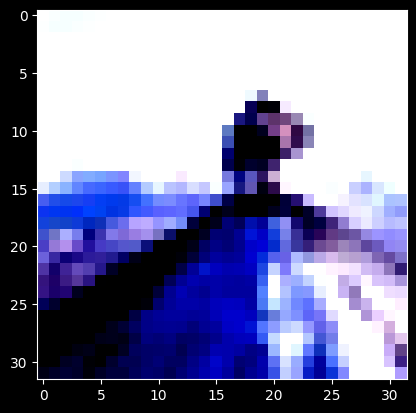

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[08/12/2024-18:34:03] [TRT] [E] IExecutionContext::enqueueV3: Error Code 3: API Usage Error (Parameter check failed, condition: inputDimensionSpecified && inputShapesSpecified. Not all shapes are specified. Following input tensors' dimensions are not specified: input.)
(100,)


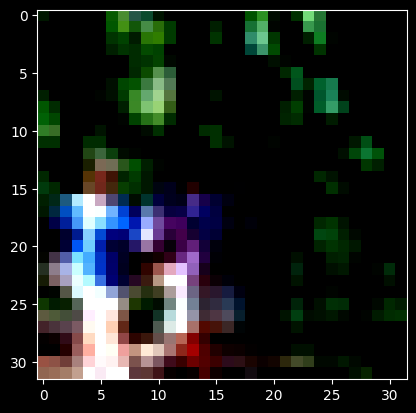

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[08/12/2024-18:34:09] [TRT] [E] IExecutionContext::enqueueV3: Error Code 3: API Usage Error (Parameter check failed, condition: inputDimensionSpecified && inputShapesSpecified. Not all shapes are specified. Following input tensors' dimensions are not specified: input.)
(100,)


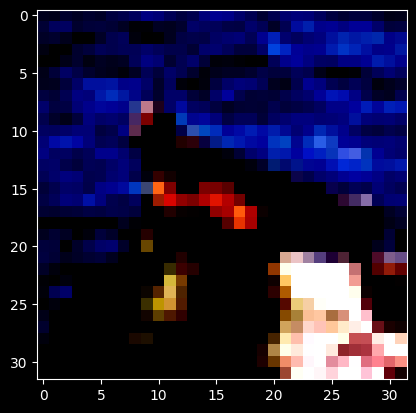

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[08/12/2024-18:34:13] [TRT] [E] IExecutionContext::enqueueV3: Error Code 3: API Usage Error (Parameter check failed, condition: inputDimensionSpecified && inputShapesSpecified. Not all shapes are specified. Following input tensors' dimensions are not specified: input.)
(100,)


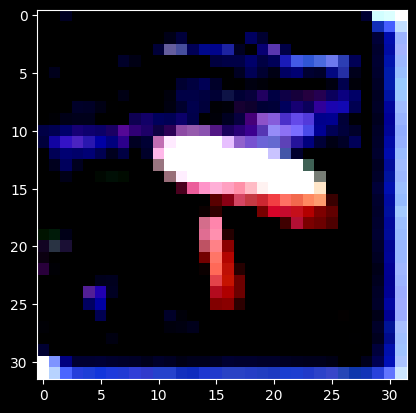

In [18]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import time
import torch
from PIL import Image
import matplotlib.pyplot as plt

BATCH_SIZE = 1

class TensorRTInference:
    def __init__(self, engine_path, BATCH_SIZE):
        self.logger = trt.Logger(trt.Logger.WARNING)
        self.runtime = trt.Runtime(self.logger)
        self.engine = self.load_engine(engine_path)
        self.context = self.engine.create_execution_context()

        # Allocate buffers
        self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers(self.engine, BATCH_SIZE)

    def load_engine(self, engine_path):
        with open(engine_path, "rb") as f:
            engine = self.runtime.deserialize_cuda_engine(f.read())
        return engine

    class HostDeviceMem:
        def __init__(self, host_mem, device_mem):
            self.host = host_mem
            self.device = device_mem

    def allocate_buffers(self, engine, batch_size=1):
        inputs, outputs, bindings = [], [], []
        stream = cuda.Stream()

        for i in range(engine.num_io_tensors):
            tensor_name = engine.get_tensor_name(i)
            size = abs(trt.volume(engine.get_tensor_shape(tensor_name))) * batch_size
            dtype = trt.nptype(engine.get_tensor_dtype(tensor_name))
            print(f"Binding: {tensor_name}, Size: {size}, Dtype: {dtype}")

            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)

            # Append the device buffer address to device bindings
            bindings.append(int(device_mem))

            # Append to the appropiate input/output list
            if engine.get_tensor_mode(tensor_name) == trt.TensorIOMode.INPUT:
                inputs.append(self.HostDeviceMem(host_mem, device_mem))
            else:
                outputs.append(self.HostDeviceMem(host_mem, device_mem))

        return inputs, outputs, bindings, stream

    def infer(self, input_data):
        # Transfer input data to device
        np.copyto(self.inputs[0].host, input_data.ravel())
        cuda.memcpy_htod_async(self.inputs[0].device, self.inputs[0].host, self.stream)

        # Set tensor address
        for i in range(self.engine.num_io_tensors):
            self.context.set_tensor_address(self.engine.get_tensor_name(i), self.bindings[i])

        # Run inference
        self.context.execute_async_v3(stream_handle=self.stream.handle)

        # Transfer predictions back
        cuda.memcpy_dtoh_async(self.outputs[0].host, self.outputs[0].device, self.stream)

        # Synchronize the stream
        self.stream.synchronize()

        return self.outputs[0].host


if __name__ == "__main__":
    # Benchmarking on the test set
    mean = [0.5059, 0.4860, 0.4411]
    std = [0.2677, 0.2561, 0.2759]
    transform_test = tt.Compose([
                                tt.ToTensor(), 
                                tt.Normalize(mean,std)
                                ])
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    total_time = 0
    total_correct = 0
    total_images = 0

    # images, labels = test_loader.__iter__().__next__()
    # img = images[0]
    # # show_image(img)
    # img_array = img.numpy().transpose(1, 2, 0)
    # plt.imshow(img_array)
    # plt.show()

    engine_path = "simple_cnn_1.trt"
    trt_inference = TensorRTInference(engine_path, BATCH_SIZE)

    for images, labels in test_loader:
        # Forward pass through TensorRT model
        start_time = time.time()
        output_data = trt_inference.infer(images.numpy())
        end_time = time.time()

        # Calculate the time taken
        total_time += (end_time - start_time)


        plt.imshow(images[0].numpy().transpose(1, 2, 0))
        print(output_data.shape)
        plt.show()
        input()
        # Compute accuracy
        # predicted = np.argmax(output_data, axis=1)
        # total_correct += np.sum(predicted == labels.numpy())
        # total_images += images.size(0)


    # img_array = np.array(img)
    # inputs = img_array.transpose(2, 0, 1)  # (3, 224, 224)
    
    # # Run inference
    # output_data = trt_inference.infer(inputs)
    # print(output_data)
